In [1]:
import csv 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import json
import re 

In [12]:
from collections import defaultdict
# get lookup of question_ids to question type and vice versa 
question_id_to_type = {}
question_type_to_id = defaultdict(list)
short_question_id_to_type = {}
question_type_to_short_id = defaultdict(list)

with open("/home/estengel/annotator_uncertainty/hit3.0/results/cleaned_data/test/test_set.csv", "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        question_id = row['Input.question_id']
        short_id  = question_id.split("_")[0]
        amb_type = '"' + row['ambiguity_type']
        # string normalize 
        amb_type = json.loads(amb_type)
        amb_type_tup = amb_type.split(".")
        amb_type_tup = [re.sub('"', '', x).strip() for x in amb_type_tup]
        amb_type_tup = [x for x in amb_type_tup if len(x) > 0]
        # amb_type_tup = ".".join(amb_type_tup)
        question_id_to_type[question_id] = ".".join(amb_type_tup)
        short_question_id_to_type[short_id] = ".".join(amb_type_tup)
        for amb_type in amb_type_tup:
            question_type_to_id[amb_type].append(question_id)
            question_type_to_short_id[amb_type].append(short_id)


In [13]:
# get ordinal results 
path = "/home/estengel/annotator_uncertainty/eval_hit/results_ordinal/full.csv"

with open(path) as f1:
    reader = csv.DictReader(f1)
    data = [x for x in reader]


In [14]:
# choice_mapping = {1: "yes", 2: "maybe", 3: "no"}
def parse_hit_data(data, choice_mapping = {1: 1, 2: 0, 3: 0}): 
    hit_data = []
    for row in data:
        qid = row['Input.qid']
        is_distractor = json.loads(row['Input.is_distractor'])
        question_type = json.loads(row['Input.question_type'])
        choice_idx = int(row['Answer.radio-input'])
        choice = choice_mapping[choice_idx]
        df_row = {"qid": json.loads(qid), "is_distractor": is_distractor, "question_type": question_type, "choice": choice}
        hit_data.append(df_row)
    df = pd.DataFrame(hit_data)
    df['choice'] *= 100
    return df 

In [24]:
hit_df = parse_hit_data(data)
df_to_plot = parse_hit_data(data)

def lookup_question_type(row):
    qid = row["qid"].split("_")[0]
    return question_id_to_type[qid]
# add a question type column to the dataframe 
hit_df_pred = hit_df[hit_df['question_type'] == "pred"]
hit_df_ann = hit_df[hit_df['question_type'] == "ann"]
hit_df_pred['amb_type'] = hit_df_pred.apply(lambda row: lookup_question_type(row), axis=1)
hit_df_ann['amb_type'] = hit_df_ann.apply(lambda row: lookup_question_type(row), axis=1)

# diff_df = hit_df[hit_df['is_distractor'] == False] - hit_df[hit_df['is_distractor'] == True]
# break df out into separate df for each question type
# new df per question type 
new_dfs = {t:None for t in question_type_to_id.keys()}
for i, question_type in enumerate(question_type_to_id.keys()):
    hit_df_pred['amb_type'].head()
    new_dfs[question_type] = hit_df_pred[hit_df_pred['amb_type'].str.contains(question_type)]
    print(f"type {question_type} has {len(new_dfs[question_type])} rows")


type U has 4 rows
type M/B has 4 rows
type M/A has 6 rows
type A/P has 14 rows
type A/C has 24 rows
type skip has 12 rows
type A/K has 42 rows
type A/L has 70 rows
type A/N has 4 rows
type A/G has 12 rows
type A/D has 4 rows
type A/T has 10 rows
type A/M has 30 rows


<ipython-input-24-b800c02a2d6b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hit_df_pred['amb_type'] = hit_df_pred.apply(lambda row: lookup_question_type(row), axis=1)
<ipython-input-24-b800c02a2d6b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hit_df_ann['amb_type'] = hit_df_ann.apply(lambda row: lookup_question_type(row), axis=1)


In [31]:
from text_cluster_search import get_scores

# get clustering results 
with open("results_test/short/pred_clusters.json") as pf, open("results_test/short/ann_clusters.json") as af:
    pred_clusters, ann_clusters = json.load(pf), json.load(af)

# get scores by question type 
scores_by_type = []
for question_type in question_type_to_id.keys():
    ids_for_qt = [x for x in question_type_to_id[question_type] if x in pred_clusters.keys()]
    not_ids_for_qt = [x for x in question_type_to_id[question_type] if x not in pred_clusters.keys()]
    # print(not_ids_for_qt)
    pred_clusters_for_qt = {x: pred_clusters[x] for x in ids_for_qt}
    ann_clusters_for_qt = {x: ann_clusters[x] for x in ids_for_qt}
    # print(question_type)
    scores = get_scores(pred_clusters_for_qt, ann_clusters_for_qt)
    scores_by_type.append({"amb_type": question_type, "precision": scores[1], "recall": scores[2], "f1": scores[0]})
    # print(scores)

scores_df = pd.DataFrame(scores_by_type)
print(scores_df.head())


  amb_type  precision    recall        f1
0        U   0.866667  0.918155  0.849927
1      M/B   0.916667  0.958333  0.927273
2      M/A   0.804167  0.850000  0.752980
3      A/P   0.810714  0.832209  0.776913
4      A/C   0.773880  0.783520  0.720035


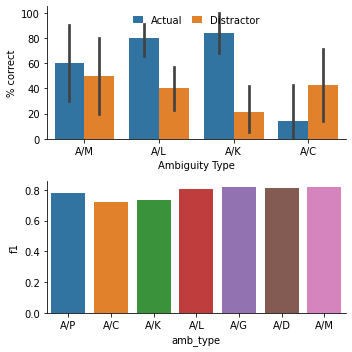

In [32]:
import pathlib
fig, ax = plt.subplots(2,1, figsize=(5,5))


subset = ['A/L', "A/K", "A/M", "A/C", "A/G", "A/P", "A/D"]

hit_df_pred = hit_df_pred[hit_df_pred['amb_type'].isin(subset)]
hit_df_ann = hit_df_ann[hit_df_ann['amb_type'].isin(subset)]
scores_df = scores_df[scores_df['amb_type'].isin(subset)]

sns.barplot(data = hit_df_pred, x = "amb_type", y = "choice", hue = "is_distractor", ax = ax[0])
sns.despine()

ax[0].set_ylabel("% correct")
ax[0].set_xlabel("Ambiguity Type")
handles, labels = ax[0].get_legend_handles_labels()
labels = ["Actual", "Distractor"]
ax[0].legend(handles=handles, labels=labels, frameon=False, loc=9, ncol=2, handlelength=1.0, columnspacing=1.0)

sns.barplot(data = scores_df, x = "amb_type", y = "f1", ax = ax[1])

plt.tight_layout()
# plt.savefig("/Users/Elias/papers/vqa-ambiguity-2022/figures/human_eval.pdf")

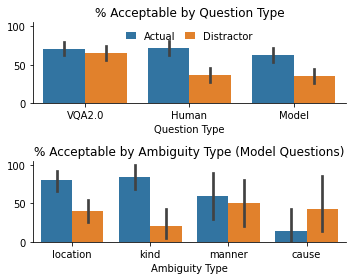

In [33]:
import pathlib
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex=False, sharey=True)

sns.barplot(data = df_to_plot, x = "question_type", y = "choice", hue = "is_distractor", ax = ax[0], order = ["orig", "ann", "pred"])
sns.despine()

ax[0].set_title("% Acceptable by Question Type")
ax[0].set_xlabel("Question Type")
handles, labels = ax[0].get_legend_handles_labels()
labels = ["Actual", "Distractor"]
ax[0].legend(handles=handles, labels=labels, frameon=False, loc=9, ncol=2, handlelength=1.0, columnspacing=1.0)
bar_lookup = {"orig": "VQA2.0", "ann": "Human", "pred": "Model"}
ax[0].set_xticklabels([bar_lookup[x.get_text()] for x in ax[0].get_xticklabels()])
ax[0].set_ylabel("")


subset = ['A/L', "A/K", "A/M", "A/C"]
amb_lookup = {"A/L": "location", "A/K": "kind", "A/M": "manner", "A/C": "cause", "A/G": "goal", "A/P": "purpose", "A/D": "direction"}

hit_df_pred = hit_df_pred[hit_df_pred['amb_type'].isin(subset)]
scores_df = scores_df[scores_df['amb_type'].isin(subset)]

sns.barplot(data = hit_df_pred, x = "amb_type", y = "choice", hue = "is_distractor", ax = ax[1], order = subset)
sns.despine()

ax[1].set_title("% Acceptable by Ambiguity Type (Model Questions)")
ax[1].set_xlabel("Ambiguity Type")
ax[1].set_xticklabels([amb_lookup[x.get_text()] for x in ax[1].get_xticklabels()])

ax[1].get_legend().remove()
ax[1].set_ylabel("")

plt.tight_layout()
plt.savefig("/home/estengel//papers/vqa-ambiguity-2022/figures/human_eval.pdf")

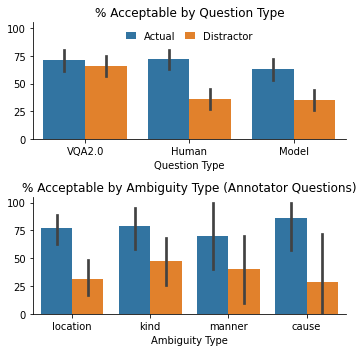

In [34]:
import pathlib
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=False, sharey=True)

# df_to_plot['choice'] *= 100
sns.barplot(data = df_to_plot, x = "question_type", y = "choice", hue = "is_distractor", ax = ax[0], order = ["orig", "ann", "pred"])
sns.despine()

ax[0].set_title("% Acceptable by Question Type")
ax[0].set_xlabel("Question Type")
handles, labels = ax[0].get_legend_handles_labels()
labels = ["Actual", "Distractor"]
ax[0].legend(handles=handles, labels=labels, frameon=False, loc=9, ncol=2, handlelength=1.0, columnspacing=1.0)
bar_lookup = {"orig": "VQA2.0", "ann": "Human", "pred": "Model"}
ax[0].set_xticklabels([bar_lookup[x.get_text()] for x in ax[0].get_xticklabels()])
ax[0].set_ylabel("")


subset = ['A/L', "A/K", "A/M", "A/C"]
amb_lookup = {"A/L": "location", "A/K": "kind", "A/M": "manner", "A/C": "cause", "A/G": "goal", "A/P": "purpose", "A/D": "direction"}

hit_df_ann = hit_df_ann[hit_df_ann['amb_type'].isin(subset)]
scores_df = scores_df[scores_df['amb_type'].isin(subset)]

# hit_df_ann['choice'] *= 100
sns.barplot(data = hit_df_ann, x = "amb_type", y = "choice", hue = "is_distractor", ax = ax[1], order = subset)
sns.despine()

ax[1].set_title("% Acceptable by Ambiguity Type (Annotator Questions)")
ax[1].set_xlabel("Ambiguity Type")
ax[1].set_xticklabels([amb_lookup[x.get_text()] for x in ax[1].get_xticklabels()])

ax[1].get_legend().remove()
ax[1].set_ylabel("")

plt.tight_layout()
# plt.savefig("/home/estengel//papers/vqa-ambiguity-2022/figures/human_eval.pdf")

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
def get_table(choice1, choice2):
    # ----------- table -------------------
    #               ann 1
    #           |-------------|-----------|------------|
    #           |             |  one      |  zero      |
    #           |-------------|-----------|------------|
    # ann 2     |  one        |           |            |
    #           |zero         |           |            |
    #           |-------------|-----------|------------|

    one_one = np.sum(choice1 * choice2)
    one_zero = np.sum(choice1 * (1-choice2))
    zero_one = np.sum((1-choice1)* choice2)
    zero_zero = np.sum((1-choice1) * (1-choice2))


    table_arr = np.zeros((2,2))

    table_arr[0,0] = one_one
    table_arr[1,0] = one_zero
    table_arr[0,1] = zero_one
    table_arr[1,1] = zero_zero
    return table_arr

def do_mcnemar(choice1, choice2):
    table_arr = get_table(choice1, choice2)
    mac = mcnemar(table_arr, exact=True, correction=False)
    return mac.pvalue, mac.statistic

In [ ]:
from itertools import product
import scipy 
from statsmodels.stats.proportion import proportions_ztest
is_distractor_choices = [True, False]
amb_type_choices = subset

poss_combos = [x for x in product(is_distractor_choices, amb_type_choices)]

done = []
for id1, qt1 in poss_combos:
    for id2, qt2 in poss_combos:
        if id1 == id2 and qt1 == qt2: 
            continue
        if id1 != id2 and qt1 != qt2: 
            # don't need to compare across conditions for different question types
            continue
        
        tup = sorted([str(x) for x in [id1, qt1, id2, qt2]])
        if tup in done:
            continue
        done.append(tup)

        d1 = hit_df[hit_df['is_distractor'] == id1][hit_df['amb_type'] == qt1]
        d2 = hit_df[hit_df['is_distractor'] == id2][hit_df['amb_type'] == qt2]
        d1 = d1['choice'].values
        d2 = d2['choice'].values
        # TODO (elias): once the last assignment is submitted, this can be cut 
        min_len = min(len(d1), len(d2))
        d1 = d1[:min_len]
        d2 = d2[:min_len]
        test = "mcnemar"
        # mcnemar only appropriate when items are paired, in this case only for the same ambiguity type
        if qt1 == qt2:
            p_value, stat = do_mcnemar(d1, d2)
        # otherwise, use 2-proportion z test
        else:
            test = "2prop"
            count1 = np.sum(d1)
            count2 = np.sum(d2)
            n1 = len(d1)
            n2 = len(d2)
            stat, p_value = proportions_ztest([count1, count2], [n1, n2])
            # stat, p_value = scipy.stats.fisher_exact(get_table(d1, d2))
            # if np.isnan(stat):
                # print(get_table(d1, d2))
                # break
            # print(f"test: {test}, amb_type 1: {qt1}, is_distractor_1: {id1}, amb_type 2: {qt2}, is_distractor 2: {id2}, stat: {stat:.2f} p_value: {p_value:.3f}")
        if p_value < 0.05:
            print(f"test: {test}, amb_type 1: {qt1}, is_distractor_1: {id1}, amb_type 2: {qt2}, is_distractor 2: {id2}, stat: {stat:.2f} p_value: {p_value:.3f}")



In [ ]:
print(len())